In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-pastel")
sns.set_theme(style="whitegrid", palette="pastel")

import os
from glob import glob

## Loading the Data

In [2]:
data_path = "data/"
def load_dataset(split: str):
    data_files = glob(f'{data_path}/{split}/*')
    data_files = [pd.read_csv(data_file) for data_file in data_files]
    split_df = pd.concat(data_files, ignore_index=True)
    return split_df

In [3]:
# Splitting the data
datasets = {"train": {"data": load_dataset("train")}, 
            "validation": {"data": load_dataset("dev")}, 
            "test": {"data": load_dataset("test")}}

all_df = pd.concat([datasets["train"]["data"], 
                    datasets["validation"]["data"],
                    datasets["test"]["data"]])

## Viewing the Data

In [4]:
datasets["train"]["data"].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1086741 entries, 0 to 1086740
Data columns (total 5 columns):
 #   Column            Non-Null Count    Dtype 
---  ------            --------------    ----- 
 0   family_id         1086741 non-null  object
 1   sequence_name     1086741 non-null  object
 2   family_accession  1086741 non-null  object
 3   aligned_sequence  1086741 non-null  object
 4   sequence          1086741 non-null  object
dtypes: object(5)
memory usage: 41.5+ MB


In [5]:
datasets["train"]["data"].head()

,family_id,sequence_name,family_accession,aligned_sequence,sequence
0,GMC_oxred_C,A4WZS5_RHOS5/416-539,PF05199.13,PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............,PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
1,DUF2887,K9QI92_9NOSO/3-203,PF11103.8,RDSIYYQIFKRFPALIFEL..VD.NRPPQAQNYRFESVEVKETAFR...,RDSIYYQIFKRFPALIFELVDNRPPQAQNYRFESVEVKETAFRIDG...
2,zf-IS66,Q92LC9_RHIME/32-75,PF13005.7,.TCCPDCGG.E..LRLVGED.AS....EILDMI.AAQMKVIEVARL...,TCCPDCGGELRLVGEDASEILDMIAAQMKVIEVARLKKSCRCCE
3,Asp_decarbox,X2GQZ4_9BACI/1-115,PF02261.16,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...,MLRMMMNSKIHRATVTEADLNYVGSITIDEDILDAVGMLPNEKVHI...
4,Filamin,A7SQM3_NEMVE/342-439,PF00630.19,TACPKQ.CTA....RGLG.............LK.AAPVT.QPT..R...,TACPKQCTARGLGLKAAPVTQPTRFVVILNDCHGQPLGRSEGELEV...


In [6]:
datasets["train"]["data"].columns

Index(['family_id', 'sequence_name', 'family_accession', 'aligned_sequence',
       'sequence'],
      dtype='object')

In [7]:
datasets["train"]["data"].iloc[0]

family_id                                                 GMC_oxred_C
sequence_name                                    A4WZS5_RHOS5/416-539
family_accession                                           PF05199.13
aligned_sequence    PHPE.SRIRLST.RRDAHGMP.....IP.RIESRLGP............
sequence            PHPESRIRLSTRRDAHGMPIPRIESRLGPDAFARLRFMARTCRAIL...
Name: 0, dtype: object

# Data Analysis

Our goal is to predict the "family accession" using the "sequence" information.

Sequences are built up of amino acids. There are 25 amino acids present in the sequences of this dataset. The "family" that a protein belongs to is determined by it's sequence. Our goal is to explore the data and attain a solid understanding of how we can best extract features such that our models can make accurate predictions.

We have 3 datasets: training, validation and testing. One thing that is worth noting is that the PFAM dataset was manually annotated (Mistry et al, 2021; https://academic.oup.com/nar/article/49/D1/D412/5943818). Therefore, there are likely to be errors in the dataset. However, it is of sufficient high quality for our purposes. Our approach for data analysis will be the following:

1) Checking for missing data
2) Dataset splits
3) Class inconsistencies between datasets
4) Class occurances
5) Sequence lengths
6) Amino acid distributions

The aim of this is not to create an exhaustative model but rather to explore the methods we can use to better extract information from the dataset to increase the accuracy of our models.

## 1) Missing Data

In [8]:
all_df.isna().sum()

family_id           0
sequence_name       0
family_accession    0
aligned_sequence    0
sequence            0
dtype: int64

All the data appears to be present meaning we don't have to manipulate the data through either filling in the dataframe using methods such as interpolation, or through the exclusion of data.

## 2) Dataset Splits

We look at the size of the dataset splits. All 3 datasets are important and have a role to play and as such it is important that they are of a suitable size.

In [9]:
def get_split_ratio(dataset):
    ''' Returns the % split of current dataset with all data '''
    return np.round((dataset.shape[0] / all_df.shape[0]) * 100, 2)

In [10]:
data_analysis_df = pd.DataFrame({
    "dataset": ["train", "validation", "test"],
    "data_count": [datasets["train"]["data"].shape[0], 
                   datasets["validation"]["data"].shape[0], 
                   datasets["test"]["data"].shape[0]],
    "data_ratio": [get_split_ratio(datasets["train"]["data"]), 
                   get_split_ratio(datasets["validation"]["data"]), 
                   get_split_ratio(datasets["test"]["data"])],
}).set_index("dataset")

data_analysis_df

,data_count,data_ratio
dataset,,
train,1086741,81.16
validation,126171,9.42
test,126171,9.42


Here we can see that the dataset follows (roughly) an 80|10|10 split. This is an acceptable split of the data for training, validation and testing.

## 3) Class Inconsistencies Between Datasets

Not only is the relative size of the datasets important, it is also important that there aren't inconsistencies between the datasets when it comes to the sequences we are trying to identify.

In [11]:
def get_unique_classes():
    ''' Returns a dictionary of the unique classes, in list form, for each dataset '''
    class_count = dict()
    for title, dataset in datasets.items():
        dataset["classes"] = dataset["data"]["family_accession"].unique()

In [12]:
get_unique_classes()

In [13]:
data_analysis_df["class_count"] = [len(datasets["train"]["classes"]), 
                                   len(datasets["validation"]["classes"]), 
                                   len(datasets["test"]["classes"])]
data_analysis_df

,data_count,data_ratio,class_count
dataset,,,
train,1086741,81.16,17929
validation,126171,9.42,13071
test,126171,9.42,13071


We can see that there are an equal number of classes in the validation and test datasets. Additionally, there are 4859 classes in the training datasets that are not in either the validation or the test datasets. 

Before we progress, we need to find the class overlaps between the validation and test datasets.

In [14]:
def get_label_overlap(dataset_classes_1, dataset_classes_2):
    ''' Returns the % overlap in unique labels between dataset 1 and dataset 2 '''
    return np.round(np.isin(dataset_classes_1, dataset_classes_2).sum() / 
                    len(dataset_classes_1) * 100, 2)

In [15]:
valid_test_class_overlap = get_label_overlap(datasets["validation"]["classes"], 
                                             datasets["test"]["classes"])
valid_train_class_overlap = get_label_overlap(datasets["train"]["classes"], 
                                             datasets["validation"]["classes"])

print(f"The validation dataset has a {valid_test_class_overlap:.1f}% overlap with the classes in the test dataset.")
print(f"The validation dataset has a {valid_train_class_overlap:.1f}% overlap with the classes in the training dataset.")

The validation dataset has a 100.0% overlap with the classes in the test dataset.
The validation dataset has a 72.9% overlap with the classes in the training dataset.


There is a 100% overlap between the validation dataset and the test dataset. This means that they have exactly the same classes. This is good. However, 27.1% of the classes in the training dataset aren't present in the validation (or test) datasets.

As this means that we cannot verify the learning of this untestable data, it is simplest to remove the samples of the unseen classes from the training dataset. However, we want to preserve as much data as possible so it is important we see the effect this would have on the dataset before we remove it.

In [16]:
removed_rows = len(datasets["train"]["data"]) - len(datasets["train"]["data"][datasets["train"]["data"]['family_accession'].isin(datasets["validation"]["classes"])])
print(f"This would remove {removed_rows} items from the training dataset.")
print(f"This is {(removed_rows / len(datasets['train']['data'])) * 100:.2f}% of the training data.")

This would remove 21791 items from the training dataset.
This is 2.01% of the training data.


This is an acceptable loss of data for the benefit we will get by not training for classes we cannot verify the learning of.

In [17]:
# Removing the samples
datasets["train"]["data"] = datasets["train"]["data"][datasets["train"]["data"]['family_accession'].isin(datasets["validation"]["classes"])]

# Adjustments to account for the shift in data
all_df = pd.concat([datasets["train"]["data"], 
                    datasets["validation"]["data"], 
                    datasets["test"]["data"]])
get_unique_classes()

data_analysis_df = pd.DataFrame({
    "dataset": ["train", "validation", "test"],
    "data_count": [datasets["train"]["data"].shape[0], 
                   datasets["validation"]["data"].shape[0], 
                   datasets["test"]["data"].shape[0]],
    "data_ratio": [get_split_ratio(datasets["train"]["data"]), 
                   get_split_ratio(datasets["validation"]["data"]), 
                   get_split_ratio(datasets["test"]["data"])],
    "class_count": [len(datasets["train"]["classes"]), len(datasets["validation"]["classes"]), 
                    len(datasets["test"]["classes"])]
}).set_index("dataset")

data_analysis_df

,data_count,data_ratio,class_count
dataset,,,
train,1064950,80.84,13071
validation,126171,9.58,13071
test,126171,9.58,13071


## 4) Class occurances

We look at the minimum, maximum and mean samples per class in each dataset. This gives us a first, albeit naive observation at the distribution of the samples per class.

Next, we plot the distribution of the number of samples per class. Ideally, this distribution is similar to a uniform distribution i.e. there are an equal number of samples per class.

In [18]:
# Minimum samples per class
data_analysis_df["min_samples_per_class"] = \
    [dataset["data"].groupby('family_accession').size().min() for title, 
                    dataset in datasets.items()]

# Maximum samples per class
data_analysis_df["max_samples_per_class"] = \
    [dataset["data"].groupby('family_accession').size().max() for title, 
                    dataset in datasets.items()]

# Mean samples per class
data_analysis_df["mean_samples_per_class"] = \
    [dataset["data"].groupby('family_accession').size().mean() for title, 
                    dataset in datasets.items()]

data_analysis_df

,data_count,data_ratio,class_count,min_samples_per_class,max_samples_per_class,mean_samples_per_class
dataset,,,,,,
train,1064950,80.84,13071,8,3637,81.474256
validation,126171,9.58,13071,1,454,9.652743
test,126171,9.58,13071,1,454,9.652743


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


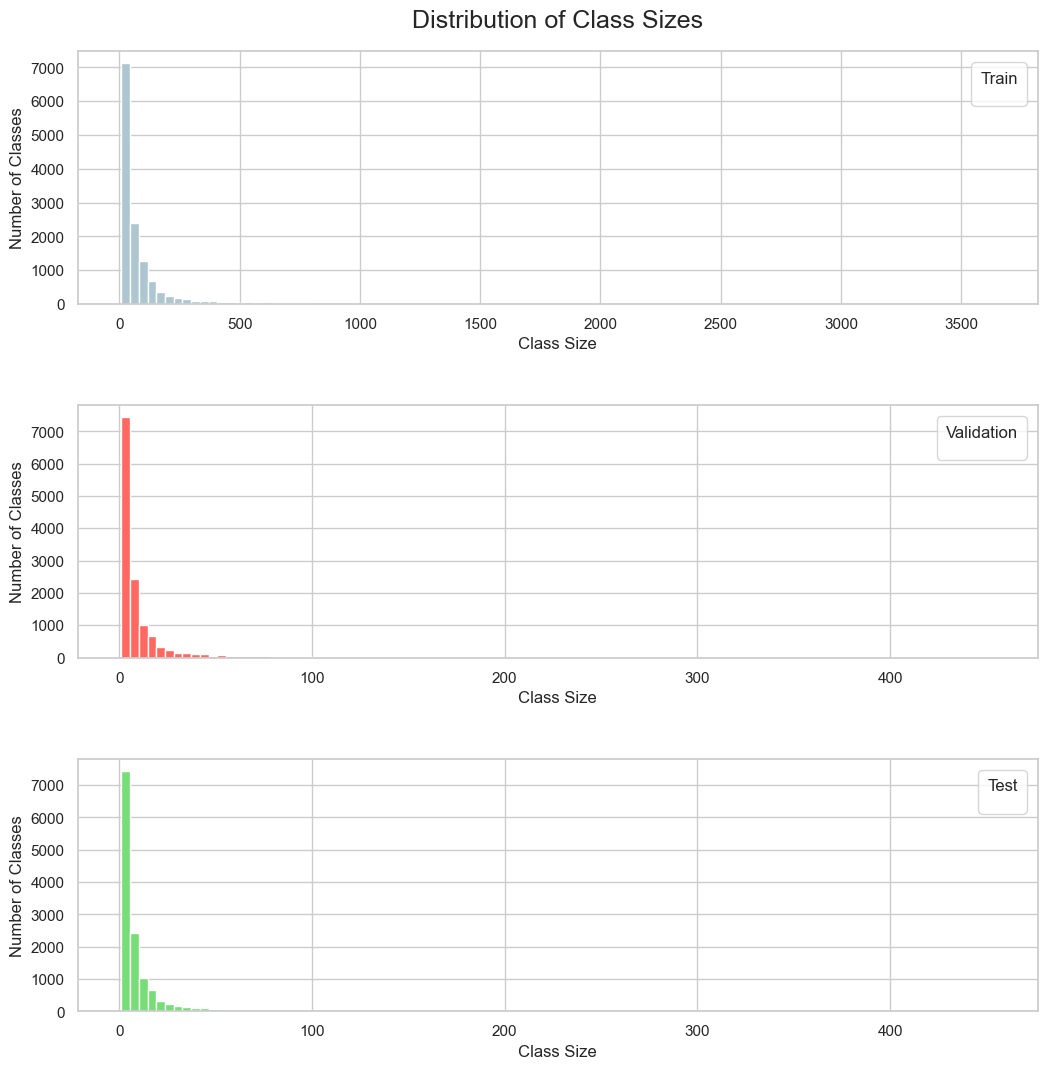

In [19]:
# Plot of the class counts
plt.figure(figsize = (12, 12))
plt.suptitle('Distribution of Class Sizes', fontsize=18, y=0.935)
colors = ["#AEC6CF", "#ff6961", "#77dd77"]

for n, (title, dataset) in enumerate(datasets.items()):
    # Create the subpot
    ax = plt.subplot(3, 1, n + 1)
    ax.legend(title=title.capitalize(), fontsize=16)
    ax.set_ylabel("Number of Classes")
    ax.set_xlabel("Class Size")
    
    # Plot data
    dataset["data"].groupby('family_id').size().hist(bins=100, ax=ax, color=colors[n])
    
plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)
plt.show()

In [20]:
print(f"The most commonly occuring class has {all_df.value_counts('family_accession').iloc[0]} occurances.")
for i in [5, 10, 25, 50, 100, 250, 500, 1000, 10000]:
    print(f"The {i}th most commonly occuring class has {all_df.value_counts('family_accession').iloc[i-1]} occurances.")
print(f"The least commonly occuring class has {all_df.value_counts('family_accession').iloc[-1]} occurances.")

The most commonly occuring class has 4545 occurances.
The 5th most commonly occuring class has 1908 occurances.
The 10th most commonly occuring class has 1512 occurances.
The 25th most commonly occuring class has 1272 occurances.
The 50th most commonly occuring class has 1017 occurances.
The 100th most commonly occuring class has 884 occurances.
The 250th most commonly occuring class has 675 occurances.
The 500th most commonly occuring class has 461 occurances.
The 1000th most commonly occuring class has 284 occurances.
The 10000th most commonly occuring class has 21 occurances.
The least commonly occuring class has 10 occurances.


The class size distributions across the datasets are relatively similar. However, there are a lot of minority classes (<500 samples per class) and few majority classes (>500 samples per class). This shows a huge class imbalance and will make training tough.

There are many different ways to get around this including: 

1) Only using majority classes
2) Resampling through either undersampling (removing "majority class" samples from the dataset, or making it less likely that they are selected in a batch) or oversampling (adding more "minority class" samples from the dataset, or making it more likely that they are selected in a batch)
3) Synthetic data generation i.e. generating samples from minority classes as an oversampling technique.
4) Punishing the model for misclassifying samples from a minority class.
5) Using ensemble learning such as having a seperate models for majority and minority classes. i.e. the majority class model focuses on all classes with >500 samples and groups all other classes into a single "group". If a sequence is flagged as being in this group it is then fed into the "minority class" model, which is trained exclusively on minority classes.

All these methods have positives and negatives. Due to a lack of time, methods 3) and 5) will not be explored. However, 1), 2) and 4) will be explored in the training phases.

## 5) Sequence lengths

We look at the lengths of the sequences. The sequences will be used that the input to our model and so it is important that they are long enough that they contain the necessary information and also short enough that the model (given our computational restrictions) is able to learn from it i.e. it would be harder for a small model to pick up significant information from a sequence of length 5000.

In [21]:
for dataset in datasets.values():
    dataset["data"]["sequence_length"] = dataset["data"]["sequence"].transform(len)
    dataset["data"]["aligned_sequence_length"] = dataset["data"]["aligned_sequence"].transform(len)

In [22]:
def plot_sequence_length(variable, title, limit):
    plt.figure(figsize = (12, 6))

    # Plotting data for each dataset
    for color, dataset in enumerate(datasets.values()):
        sns.histplot(data=dataset["data"][variable], bins=100, alpha=0.2, kde=True, 
                     multiple="stack", stat="probability", color=colors[color], edgecolor='grey')
    plt.suptitle(title + " Length Distributions", fontsize=20, y=0.95)
    plt.legend(['Train', 'Validation', 'Test'], fontsize=14)
    plt.xlabel(title + " Length", fontsize=14)
    plt.ylabel("Proportion", fontsize=14)

    # 600 is a suitable cut-off point for visualisation of the data.
    # Also, our model input is likely to be far shorter than this.
    plt.xlim(0, limit)
    plt.show()

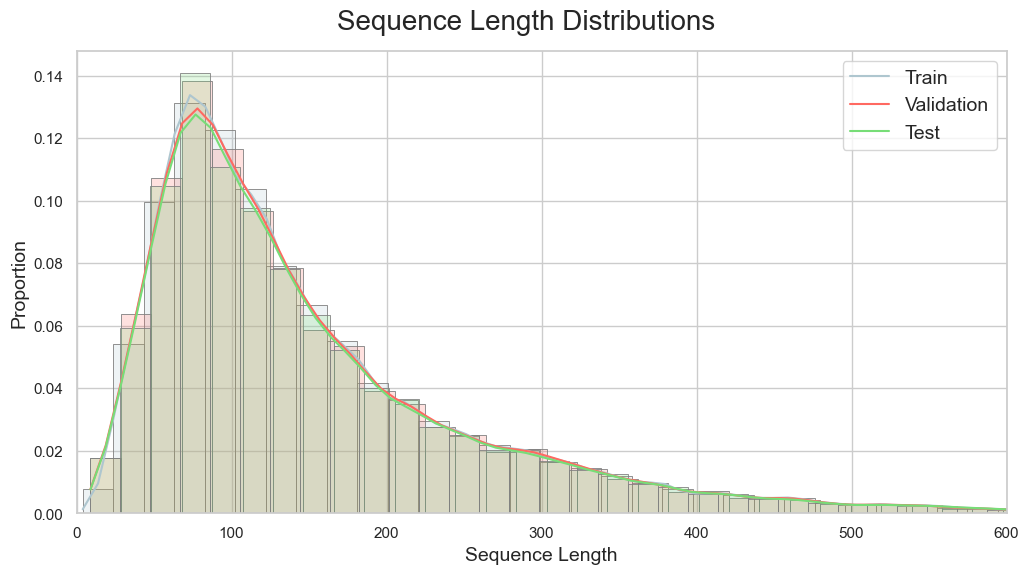

In [23]:
plot_sequence_length("sequence_length", "Sequence", 600)

In [24]:
print(f"The highest sequence length in the training dataset is {np.sort(datasets['train']['data']['sequence_length'])[-1]}.")
for i in [5, 10, 25, 50, 100, 250, 500, 1000, 10000]:
    print(f"The {i}th highest sequence length in the training dataset is {np.sort(datasets['train']['data']['sequence_length'])[-i]}.")
print(f"The shortest sequence length in the training dataset is {np.sort(datasets['train']['data']['sequence_length'])[0]}.")

The highest sequence length in the training dataset is 1972.
The 5th highest sequence length in the training dataset is 1941.
The 10th highest sequence length in the training dataset is 1924.
The 25th highest sequence length in the training dataset is 1715.
The 50th highest sequence length in the training dataset is 1641.
The 100th highest sequence length in the training dataset is 1534.
The 250th highest sequence length in the training dataset is 1289.
The 500th highest sequence length in the training dataset is 1108.
The 1000th highest sequence length in the training dataset is 940.
The 10000th highest sequence length in the training dataset is 589.
The shortest sequence length in the training dataset is 4.


The distribution of the length of sequences is also very imbalanced. However, unlike in the class imbalances, the majority of sequences are within a sensible "band" i.e. less than 250. For those longer than 250 we can still use these samples, but we will have to cut them. This is a standard practice within NLP. We will lose some information, but we are maintaining as much as possible whilst still keeping the model trainable.

Studies suggest that protein domains are on average 100 amino acids (AA) long, typically between 50 and 200 AAs long, with 90% being less than 200 long (https://www.pnas.org/doi/full/10.1073/pnas.1207382109). Our data agrees with this.

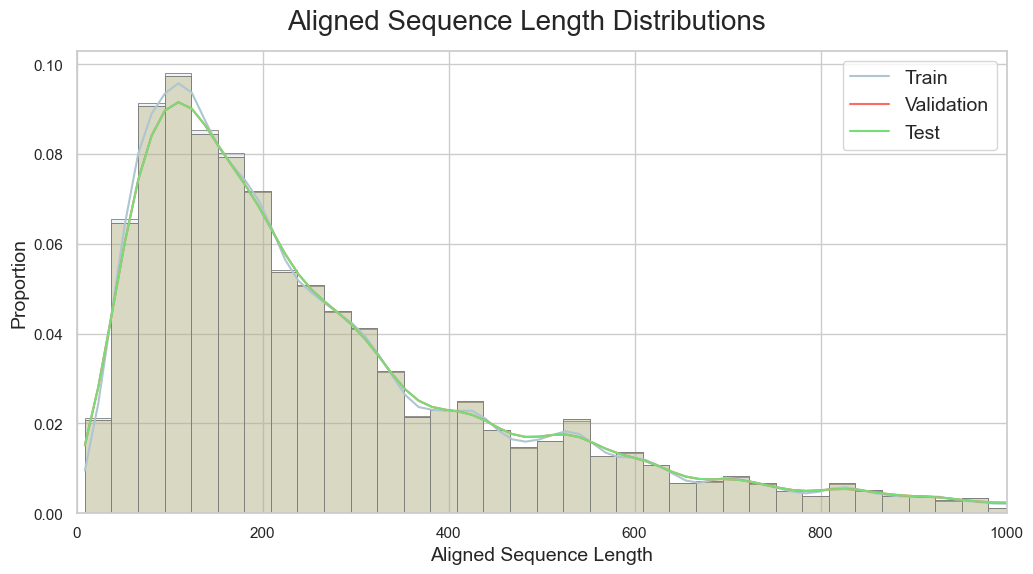

In [25]:
plot_sequence_length("aligned_sequence_length", "Aligned Sequence", 1000)

In [26]:
print(f"The highest aligned sequence length in the training dataset is {np.sort(datasets['train']['data']['aligned_sequence_length'])[-1]}.")
for i in [5, 10, 25, 50, 100, 250, 500, 1000, 10000]:
    print(f"The {i}th highest aligned sequence length in the training dataset is {np.sort(datasets['train']['data']['aligned_sequence_length'])[-i]}.")
print(f"The shortest aligned sequence length in the training dataset is {np.sort(datasets['train']['data']['aligned_sequence_length'])[0]}.")

The highest aligned sequence length in the training dataset is 2866.
The 5th highest aligned sequence length in the training dataset is 2866.
The 10th highest aligned sequence length in the training dataset is 2866.
The 25th highest aligned sequence length in the training dataset is 2866.
The 50th highest aligned sequence length in the training dataset is 2866.
The 100th highest aligned sequence length in the training dataset is 2394.
The 250th highest aligned sequence length in the training dataset is 2394.
The 500th highest aligned sequence length in the training dataset is 2197.
The 1000th highest aligned sequence length in the training dataset is 2197.
The 10000th highest aligned sequence length in the training dataset is 1363.
The shortest aligned sequence length in the training dataset is 9.


I thought it would be interesting to compare the aligned sequence lengths with the sequence lengths. As you can see from the graph above, on average they are longer there is a larger relative tail. This is because the aligned sequence length contains more information than the sequence length alone. However, to use this as the input, rather than the sequence length would require a much larger input size into the model to ensure we're not losing too much information. This would require more computation and time for testing that is available to me.

## 6) Amino acid distributions

The sequences are made up of amino acids. We need to observe the distribution of amino acids as we have the classes and sequence lengths. Ideally, there is an equal number of each amino acid present across the datasets. 

In [27]:
amino_acid_count = {"all": {}, "train": {}, "validation": {}, "test": {}}

for title, dataset in datasets.items():
    for sequence in dataset["data"]["sequence"]:
        sequence_list = list(sequence)
        for aa in sequence_list:
            if aa in amino_acid_count[title]:
                amino_acid_count[title][aa] += 1
                amino_acid_count["all"][aa] += 1
            elif aa in amino_acid_count["all"]:
                amino_acid_count["all"][aa] += 1
                amino_acid_count[title][aa] = 1
            else: 
                amino_acid_count["all"][aa] = 1
                amino_acid_count[title][aa] = 1
            

In [28]:
amino_acid_count_df = pd.DataFrame(columns=["dataset", "amino_acid", "count"])

for dataset, aa_count in amino_acid_count.items():
    for aa, count in aa_count.items():
        amino_acid_count_df.loc[len(amino_acid_count_df)] = [dataset, aa, count]
        
amino_acid_count_order = amino_acid_count_df[amino_acid_count_df["dataset"] == "all"].sort_values("count", ascending=False).amino_acid.tolist()

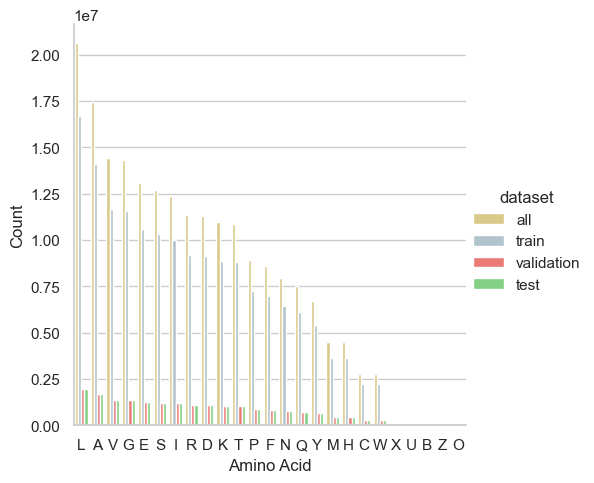

In [29]:
#plt.figure(figsize=(100, 1))
sns.catplot(data=amino_acid_count_df, x="amino_acid", y="count",
            hue="dataset", kind="bar", order=amino_acid_count_order,
            palette=sns.color_palette(["#E7D27C", colors[0], colors[1], colors[2]]))
plt.ylabel("Count")
plt.xlabel("Amino Acid")
plt.show()

We can see that there is, once again, an imbalanced distribution of amino acids in the sequences, particularly for "X", "U", "B", "O" and "Z", which are barely present in the data.

We will deal with this in the data preprocessing stage.

For a full study, I would also like to look into the distribution of kmers and the prevelance of repeating substrings.

kmers are sub-strings of amino acids i.e. "LA" is 2-mer and "GES" is a 3-mer. It the domains of structure prediction and family classification it has been shown that inclusion of kmers into the model has the potential to increase the accuracy of the model (Madera et Al 2010; https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2828123/, Guo et Al 2021; https://doi.org/10.3389/fgene.2021.797641.

# Saving Data

We have performed our data analysis and the data will be precessed according to our findings during the data-preprocessing stage i.e. cutting sequence length, removing minority classes, amino acid grouping, etc. However, we have made changes that will remain permanent, such as removing data that is un testable and we will save this data so that our data preprocessing is simpler.

In [30]:
# Removing unwanted columns from the dataframe so csv files are smaller
datasets["train"]["data"] = datasets["train"]["data"].drop(columns=["family_id", "sequence_name", "aligned_sequence", "sequence_length", "aligned_sequence_length"])
datasets["validation"]["data"] = datasets["validation"]["data"].drop(columns=["family_id", "sequence_name", "aligned_sequence", "sequence_length", "aligned_sequence_length"])
datasets["test"]["data"] = datasets["test"]["data"].drop(columns=["family_id", "sequence_name", "aligned_sequence", "sequence_length", "aligned_sequence_length"])

In [31]:
datasets["train"]["data"].to_csv('data/train.csv', index=False)
datasets["validation"]["data"].to_csv('data/validation.csv', index=False)  
datasets["test"]["data"].to_csv('data/test.csv', index=False)  

## Removing Minority Classes

Due to computation and time restrctions, we will use the dataset with class sizes of 100. This will allow us enough data to train models and to see which modelr perform best. If I had more time and resources I would expand the number of classes used.

The main issue across the dataset is the imbalance of samples in the different classes. For this reason, we will be saving datasets with varying levels of imbalance. A variable, "k", will be used for this. The method is to order the classes from most common to least common, then, starting at the most common, select every "kth" class to be included in the data set.

If k=1, then this will simply be the top 100 most common classes.

If k=2, this will be every other class i.e. most popular, 3rd most popular, ..., 201st most popular.

If k=10, this will select every 10th class i.e. most popular, 11th most popular, ..., 1001st most popular.

In [32]:
def remove_minority_classes(k):
    ''' Removes all but the top 100 most common classes with an interval of k '''
    majority_classes = list(datasets["train"]["data"]['family_accession'].value_counts().index)[:100*k:k]

    data_count = []
    new_datasets = []
    for title, dataset in datasets.items():
        dataset = dataset["data"][dataset["data"]['family_accession'].isin(majority_classes)]
        data_count.append(len(dataset))
        new_datasets.append(dataset)


        name = title + "_" + str(k)
        dataset.to_csv("data/" + name + ".csv", index=False)
        
    total_data_count = sum(data_count)
    data_analysis_df = pd.DataFrame({
    "dataset": ["train", "validation", "test"],
    "data_count": [data_count[0], data_count[1], data_count[2]], 
     "data_ratio": [100 * data_count[0] / total_data_count, 
                    100 * data_count[1] / total_data_count, 
                    100 * data_count[2] / total_data_count],
    })
    return data_analysis_df

In [33]:
print(remove_minority_classes(1), end="\n\n")
print(remove_minority_classes(3), end="\n\n")
print(remove_minority_classes(10), end="\n\n")
print(remove_minority_classes(30), end="\n\n")
print(remove_minority_classes(100), end="\n\n")

      dataset  data_count  data_ratio
0       train       92983   80.079750
1  validation       11565    9.960125
2        test       11565    9.960125

      dataset  data_count  data_ratio
0       train       71634   80.095264
1  validation        8901    9.952368
2        test        8901    9.952368

      dataset  data_count  data_ratio
0       train       46313   80.138776
1  validation        5739    9.930612
2        test        5739    9.930612

      dataset  data_count  data_ratio
0       train       26625   80.251379
1  validation        3276    9.874311
2        test        3276    9.874311

      dataset  data_count  data_ratio
0       train       13345   80.551699
1  validation        1611    9.724150
2        test        1611    9.724150



We can therefore establish how our models deal with unbalanced data without requiring additional computing resources. The downside of this is that we have increasingly smaller datasets as we use less common classes. This is unideal, but it will allow us to see how the model learns with imbalanced data.

These datasets also contain a 80|10|10 split, which is a suitable split.